In [1]:
from google.colab import userdata
import os
import kagglehub
import shutil
import random
from collections import defaultdict
import numpy as np

path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print(f"Dataset downloaded successfully to: {path}")

data_dir = os.path.join(path, 'data')
print("\nContents of the data directory:")
print(os.listdir(data_dir))


import os
total_size_bytes = 0
for dirpath, dirnames, filenames in os.walk(path):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size_bytes += os.path.getsize(fp)

total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total dataset size on disk: {total_size_mb:.2f} MB\n")


data_dir = os.path.join(path, 'data')

if os.path.exists(data_dir):
    print("Image count per category:")
    print("-" * 25)

    total_images = 0
    categories = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for category in categories:
        category_path = os.path.join(data_dir, category)
        num_images = len(os.listdir(category_path))
        total_images += num_images
        print(f"- {category:<12}: {num_images} images")

    print("-" * 25)
    print(f"Total number of images: {total_images}")

else:
    print(f"Error: Could not find the 'data' directory inside {path}")

try:
    if not os.path.isdir(data_dir):
        print(f"Error: The directory '{data_dir}' does not exist.")
        print("Please make sure you have run the dataset download cell first.")
except NameError:
    print("Error: The 'data_dir' variable is not defined.")
    print("Please make sure you have run the dataset download cell first.")


base_split_dir = 'split_data'
if os.path.exists(base_split_dir):
    shutil.rmtree(base_split_dir)
os.makedirs(base_split_dir, exist_ok=True)

train_dir = os.path.join(base_split_dir, 'train')
validation_dir = os.path.join(base_split_dir, 'validation')
test_dir = os.path.join(base_split_dir, 'test')



categories = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for split_dir in [train_dir, validation_dir, test_dir]:
    for category in categories:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

print(f"Created new directory structure inside '{base_split_dir}'\n")


file_counts = defaultdict(lambda: defaultdict(int))
print("Splitting files for each category...")

for category in categories:
    source_category_dir = os.path.join(data_dir, category)
    files = os.listdir(source_category_dir)
    random.shuffle(files)

    train_ratio, val_ratio = 0.8, 0.1

    train_end = int(len(files) * train_ratio)
    validation_end = train_end + int(len(files) * val_ratio)

    train_files = files[:train_end]
    validation_files = files[train_end:validation_end]
    test_files = files[validation_end:]

    splits = {
        'train': (train_files, train_dir),
        'validation': (validation_files, validation_dir),
        'test': (test_files, test_dir)
    }

    for split_name, (file_list, dest_dir) in splits.items():
        dest_category_dir = os.path.join(dest_dir, category)
        for f in file_list:
            shutil.copy(os.path.join(source_category_dir, f), dest_category_dir)
        file_counts[split_name][category] = len(file_list)

print("Data splitting complete.\n")


print("--- Split Summary ---")
print(f"{'Category':<12} | {'Train':<10} | {'Validation':<12} | {'Test':<10}")
print("-" * 55)

totals = defaultdict(int)
for category in categories:
    train_count = file_counts['train'][category]
    val_count = file_counts['validation'][category]
    test_count = file_counts['test'][category]

    totals['train'] += train_count
    totals['validation'] += val_count
    totals['test'] += test_count

    print(f"{category:<12} | {train_count:<10} | {val_count:<12} | {test_count:<10}")

print("-" * 55)
print(f"{'Total':<12} | {totals['train']:<10} | {totals['validation']:<12} | {totals['test']:<10}")
print(f"\nYour split dataset is now ready in the '{base_split_dir}' directory.")



100%|██████████| 21.8M/21.8M [00:00<00:00, 151MB/s]

Extracting files...


Dataset downloaded successfully to: /root/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1

Contents of the data directory:
['water', 'cloudy', 'desert', 'green_area']
Total dataset size on disk: 21.53 MB

Image count per category:
-------------------------
- cloudy      : 1500 images
- desert      : 1131 images
- green_area  : 1500 images
- water       : 1500 images
-------------------------
Total number of images: 5631
Created new directory structure inside 'split_data'

Splitting files for each category...
Data splitting complete.

--- Split Summary ---
Category     | Train      | Validation   | Test      
-------------------------------------------------------
cloudy       | 1200       | 150          | 150       
desert       | 904        | 113          | 114       
green_area   | 1200       | 150          | 150       
water        | 1200       | 150          | 150       
-------------------------------------------------------
Total        | 4504   

In [2]:
import tensorflow as tf
import os
import numpy as np


train_dir = 'split_data/train'
validation_dir = 'split_data/validation'
test_dir = 'split_data/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


print("Loading and preprocessing datasets...")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,

    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\nDatasets created successfully.")
for images, labels in train_dataset.take(1):
    print("\n--- Verification ---")
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Shape of one batch of labels: {labels.shape}")
    break



Loading and preprocessing datasets...
Found 4504 files belonging to 4 classes.
Found 563 files belonging to 4 classes.
Found 564 files belonging to 4 classes.

Datasets created successfully.

--- Verification ---
Shape of one batch of images: (32, 224, 224, 3)
Shape of one batch of labels: (32, 4)


In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

print("---Preparing Data and Training Model ---")

train_dir = 'split_data/train'
validation_dir = 'split_data/validation'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 3
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

---Preparing Data and Training Model ---


In [33]:
#  Load Raw Datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')

Found 4504 files belonging to 4 classes.
Found 563 files belonging to 4 classes.


In [34]:
# Define Augmentation and Preparation Functions ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

def prepare_dataset(ds, augment=False, shuffle=False):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

aug_train_ds = prepare_dataset(train_dataset, augment=True, shuffle=True)
val_ds = prepare_dataset(validation_dataset)
print("Training and validation datasets created successfully.")

Training and validation datasets created successfully.


In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

print("--- Step 1: Preparing Data and Training CNN ---")

train_dir = 'split_data/train'
validation_dir = 'split_data/validation'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

def prepare_dataset(ds, augment=False, shuffle=False):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

aug_train_ds = prepare_dataset(train_dataset, augment=True, shuffle=True)
val_ds = prepare_dataset(validation_dataset)
print("Training and validation datasets created successfully.")

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_1'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(
    aug_train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)
print("\nModel training complete.")


--- Step 1: Preparing Data and Training CNN ---
Found 4504 files belonging to 4 classes.
Found 563 files belonging to 4 classes.
Training and validation datasets created successfully.
Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 243ms/step - accuracy: 0.7883 - loss: 0.5364 - val_accuracy: 0.8970 - val_loss: 0.2133
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - accuracy: 0.9097 - loss: 0.2218 - val_accuracy: 0.9218 - val_loss: 0.1659
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.9202 - loss: 0.1813 - val_accuracy: 0.9254 - val_loss: 0.1638
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - accuracy: 0.9188 - loss: 0.1715 - val_accuracy: 0.9290 - val_loss: 0.1660
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.9300 - loss: 0.1513 - val_accuracy: 0.9165 - val_loss: 0.1700
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.9187 - loss: 0.1708 - val_accuracy: 0.9414 - val_loss: 0.1310
Epoch 7/15
141/141 ━━━━━━━━━━━

In [52]:
import numpy as np
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Creates the Grad-CAM heatmap using a more stable method."""
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[model.layers.index(last_conv_layer) + 1:]:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    """Overlays the heatmap on the original image."""
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


Generating the Final Heatmaps for 4 Random Test Images ---
Found 564 files belonging to 4 classes.
Test dataset loaded successfully.
Using model: Base CNN. Last conv layer: 'conv2d_2'


/tmp/ipython-input-52-1688837787.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


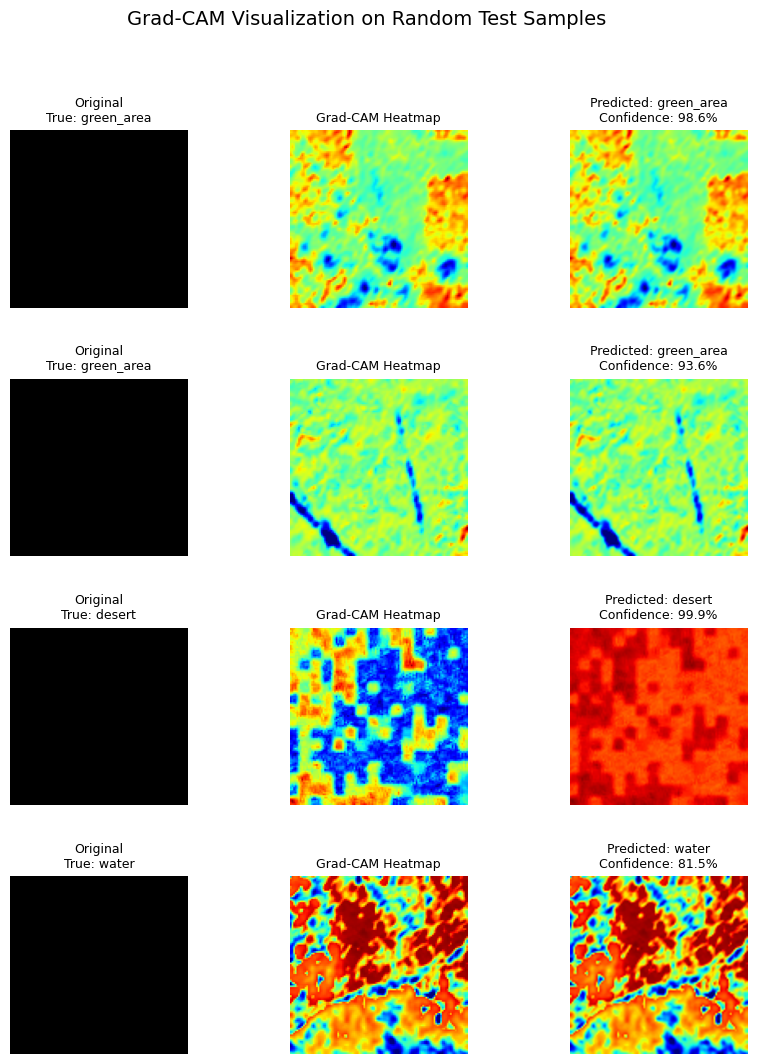

In [61]:
print("Generating the Final Heatmaps for 4 Random Test Images ---")

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import random

# Q1 Journal-style Matplotlib settings
mpl.rcParams.update({
    'font.size': 9,
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.titlesize': 12,
    'savefig.dpi': 300,
    'axes.linewidth': 0.8
})

# Load and prepare test dataset
test_dir = 'split_data/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False
)
test_ds = prepare_dataset(test_dataset)
print("Test dataset loaded successfully.")

# Set model and last conv layer
model_to_visualize = cnn_model
last_conv_layer_name = 'conv2d_2'
print(f"Using model: Base CNN. Last conv layer: '{last_conv_layer_name}'")

# Get class names
class_names = test_dataset.class_names

# Collect 4 random test samples
all_images = []
for img_batch, label_batch in test_ds:
    for img, label in zip(img_batch, label_batch):
        all_images.append((img, label))
random_samples = random.sample(all_images, 4)

# Create figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle("Grad-CAM Visualization on Random Test Samples", fontsize=14)

for row_idx, (sample_image, label) in enumerate(random_samples):
    img_array = np.expand_dims(sample_image, axis=0)

    # Generate heatmap and overlay
    heatmap = make_gradcam_heatmap(img_array, model_to_visualize, last_conv_layer_name)
    superimposed_image = display_gradcam(sample_image.numpy(), heatmap)

    # Model prediction
    preds = model_to_visualize.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(preds[0])
    confidence = np.max(preds[0]) * 100
    true_class_index = np.argmax(label.numpy())

    # Plot Original Image
    ax1 = axes[row_idx, 0]
    ax1.imshow(sample_image.numpy().astype("uint8"))
    ax1.set_title(f"Original\nTrue: {class_names[true_class_index]}", fontsize=9)
    ax1.axis('off')

    # Plot Heatmap Only
    ax2 = axes[row_idx, 1]
    ax2.imshow(heatmap, cmap='jet')
    ax2.set_title("Grad-CAM Heatmap", fontsize=9)
    ax2.axis('off')

    # Plot Overlay
    ax3 = axes[row_idx, 2]
    ax3.imshow(superimposed_image)
    ax3.set_title(f"Predicted: {class_names[predicted_class_index]}\nConfidence: {confidence:.1f}%", fontsize=9)
    ax3.axis('off')

plt.show()
